In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from cosinorage.dataloaders import DataLoader
from cosinorage.features import WearableFeatures


In [2]:
def remove_bytes(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.select_dtypes([object]):  # Select columns with object type (likely byte strings)
        df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
    return df


In [3]:
day_g = pd.read_sas("../data/PAXDAY_G.xpt")
day_h = pd.read_sas("../data/PAXDAY_H.xpt")
day_g = day_g[day_g['seqn'] == id]
day_h = day_h[day_h['seqn'] == id]

nha1 = pd.concat([day_g, day_h])
nha1.columns = nha1.columns.str.lower()
nha1 = remove_bytes(nha1)
len(nha1)

130186

In [4]:
nha1.head()

,seqn,paxdayd,paxdaywd,paxssndp,paxmstd,paxtmd,paxaismd,paxvmd,paxmtsd,paxwwmd,paxswmd,paxnwmd,paxumd,paxlxsd,paxqfd
0,62161.0,1,7,5.397605e-79,12:30:00,690.0,1426946.0,690.0,4636.399,508.0,139.0,5.397605e-79,43.0,49185.11,5.397605e-79
1,62161.0,2,1,3.312000e+06,0:00:00,1440.0,3123802.0,1440.0,12531.363,816.0,548.0,5.397605e-79,76.0,433309.24,5.397605e-79
2,62161.0,3,2,1.022400e+07,0:00:00,1440.0,2779464.0,1440.0,14013.228,921.0,462.0,5.397605e-79,57.0,475977.11,5.397605e-79
3,62161.0,4,3,1.713600e+07,0:00:00,1440.0,2724602.0,1440.0,16982.386,911.0,472.0,5.397605e-79,57.0,208827.73,5.397605e-79
4,62161.0,5,4,2.404800e+07,0:00:00,1440.0,3144826.0,1440.0,11718.500,854.0,504.0,5.397605e-79,82.0,114269.65,5.397605e-79


In [5]:
# Step 1: Unique SEQN
nha1_seqn = nha1['seqn'].drop_duplicates()
a1 = nha1_seqn.shape[0]
a1

14693

In [6]:
# Step 2: Data quality flag
nha2 = nha1[nha1['paxqfd'] < 1]
nha2_seqn = nha2['seqn'].drop_duplicates()
a2 = nha2_seqn.shape[0]
a2


14666

In [7]:
# Step 3: Valid wear hours and days
nha3_hrs = nha2.assign(valid_hours=(nha2['paxwwmd'] + nha2['paxswmd']) / 60)
nha3_hrs = nha3_hrs[nha3_hrs['valid_hours'] > 16]

nha3_days = nha3_hrs.groupby('seqn').filter(lambda x: len(x) >= 4)
nha3_seqn = nha3_days['seqn'].drop_duplicates()
a3 = nha3_seqn.shape[0]
a3

11503

In [8]:
# Step 4: Minute-level data

def clean_data(df: pd.DataFrame, days: pd.DataFrame) -> pd.DataFrame:
    df = df[df['SEQN'].isin(days['seqn'])]
    df = df[df['PAXMTSM'] != -0.01]
    df = df[~df['PAXPREDM'].isin([3, 4])]
    df = df[df['PAXQFM'] < 1]
    return df

itr_g = pd.read_sas("../data/PAXMIN_G.xpt", chunksize=100000)
min_g = []
for chunk in itr_g:
    min_g.append(clean_data(chunk, nha3_days))
min_g = pd.concat(min_g, ignore_index=True)

itr_h = pd.read_sas("../data/PAXMIN_H.xpt", chunksize=100000)
min_h = []
for chunk in itr_h:
    min_h.append(clean_data(chunk, nha3_days))
min_h = pd.concat(min_h, ignore_index=True)

min_data = pd.concat([min_g, min_h], ignore_index=True).rename(columns=str.lower)
min_data = remove_bytes(min_data)
len(min_data)

132019377

In [9]:
# Step 5: Add header data
head_g = pd.read_sas("../data/PAXHD_G.xpt")
head_h = pd.read_sas("../data/PAXHD_H.xpt")
head_g = head_g[head_g['seqn'] == id]
head_h = head_h[head_h['seqn'] == id]

header = pd.concat([head_g, head_h], ignore_index=True).rename(columns=str.lower)
header = header[['seqn', 'paxftime', 'paxfday']].rename(columns={
    'paxftime': 'day1_start_time', 'paxfday': 'day1_which_day'
})

min2 = min_data.merge(header, on='seqn')
header = remove_bytes(min2)
print(min2.shape)

(132019377, 18)


In [10]:
min2 = min2[min2['seqn'] == 62164]

In [11]:
# Step 6: Add epochs
def calculate_measure_time(row):
    base_time = datetime.strptime(row['day1_start_time'], "%H:%M:%S")
    measure_time = base_time + timedelta(seconds=row['paxssnmp'] / 80)
    return measure_time

min2['measure_time'] = min2.apply(calculate_measure_time, axis=1)
min2['measure_hour'] = min2['measure_time'].dt.hour
min2.tail()

/var/folders/wl/n18csb_91230dq8v__mxqxxr0000gn/T/ipykernel_49497/2930235457.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min2['measure_time'] = min2.apply(calculate_measure_time, axis=1)
/var/folders/wl/n18csb_91230dq8v__mxqxxr0000gn/T/ipykernel_49497/2930235457.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min2['measure_hour'] = min2['measure_time'].dt.hour


,seqn,paxdaym,paxdaywm,paxssnmp,paxtsm,paxaismm,paxmtsm,paxmxm,paxmym,paxmzm,paxpredm,paxtranm,paxlxsm,paxlxsdm,paxqfm,paxflgsm,day1_start_time,day1_which_day,measure_time,measure_hour
11529,62164.0,1,1,5.397605e-79,60.0,4.020000e+02,3.918,1.140,1.130,1.649,1,0,791.94,52.88,5.397605e-79,,12:30:00,1,1900-01-01 12:30:00,12
11530,62164.0,1,1,4.800000e+03,60.0,8.100000e+01,13.338,4.095,4.148,5.095,1,0,894.00,397.11,5.397605e-79,,12:30:00,1,1900-01-01 12:31:00,12
11531,62164.0,1,1,9.600000e+03,60.0,5.397605e-79,8.012,1.807,3.105,3.100,1,0,1023.50,119.02,5.397605e-79,,12:30:00,1,1900-01-01 12:32:00,12
11532,62164.0,1,1,1.440000e+04,60.0,5.397605e-79,3.262,1.382,1.009,0.871,1,0,1003.85,162.22,5.397605e-79,,12:30:00,1,1900-01-01 12:33:00,12
11533,62164.0,1,1,1.920000e+04,60.0,5.397605e-79,2.117,0.817,0.582,0.719,1,0,1135.40,39.47,5.397605e-79,,12:30:00,1,1900-01-01 12:34:00,12


In [12]:
valid_startend = min2.groupby(['seqn', 'paxdaym']).agg(
    start=('measure_hour', 'min'),
    end=('measure_hour', 'max')
).reset_index()

min3 = min2.merge(valid_startend, on=['seqn', 'paxdaym'])
min3 = min3[(min3['start'] == 0) & (min3['end'] == 23)]

min3['measure_min'] = min3['measure_time'].dt.minute
min3['myepoch'] = (12 * min3['measure_hour'] + np.floor(min3['measure_min'] / 5 + 1)).astype(int)

epoch = min3[['seqn', 'paxdaym', 'myepoch']].drop_duplicates()

check = epoch.groupby(['seqn', 'paxdaym']).size().reset_index(name='n_epoch')
epoch2 = epoch.merge(check, on=['seqn', 'paxdaym'])
epoch2 = epoch2[epoch2['n_epoch'] == 288]

check2 = epoch2.groupby('seqn').size().reset_index(name='n_days')
epoch3 = epoch2.merge(check2, on='seqn')
epoch3 = epoch3[epoch3['n_days'] >= 4]

nha4 = epoch3[['seqn']].drop_duplicates()
a4 = nha4.shape[0]
print(a4)

1


In [14]:
min3.head()

,seqn,paxdaym,paxdaywm,paxssnmp,paxtsm,paxaismm,paxmtsm,paxmxm,paxmym,paxmzm,...,paxqfm,paxflgsm,day1_start_time,day1_which_day,measure_time,measure_hour,start,end,measure_min,myepoch
690,62164.0,2,2,3312000.0,60.0,4800.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,...,5.397605e-79,,12:30:00,1,1900-01-02 00:00:00,0,0,23,0,1
691,62164.0,2,2,3316800.0,60.0,4800.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,...,5.397605e-79,,12:30:00,1,1900-01-02 00:01:00,0,0,23,1,1
692,62164.0,2,2,3321600.0,60.0,4800.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,...,5.397605e-79,,12:30:00,1,1900-01-02 00:02:00,0,0,23,2,1
693,62164.0,2,2,3326400.0,60.0,4800.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,...,5.397605e-79,,12:30:00,1,1900-01-02 00:03:00,0,0,23,3,1
694,62164.0,2,2,3331200.0,60.0,4800.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,...,5.397605e-79,,12:30:00,1,1900-01-02 00:04:00,0,0,23,4,1


In [18]:
# rename columns x, y and z and timestamp index
data = min3.rename(columns={
    'paxmxm': 'x', 'paxmym': 'y', 'paxmzm': 'z', 'measure_time': 'timestamp'
})
data.set_index('timestamp', inplace=True)
data = data[['x', 'y', 'z']]
data.head()

,x,y,z
timestamp,,,
1900-01-02 00:00:00,5.397605e-79,5.397605e-79,5.397605e-79
1900-01-02 00:01:00,5.397605e-79,5.397605e-79,5.397605e-79
1900-01-02 00:02:00,5.397605e-79,5.397605e-79,5.397605e-79
1900-01-02 00:03:00,5.397605e-79,5.397605e-79,5.397605e-79
1900-01-02 00:04:00,5.397605e-79,5.397605e-79,5.397605e-79


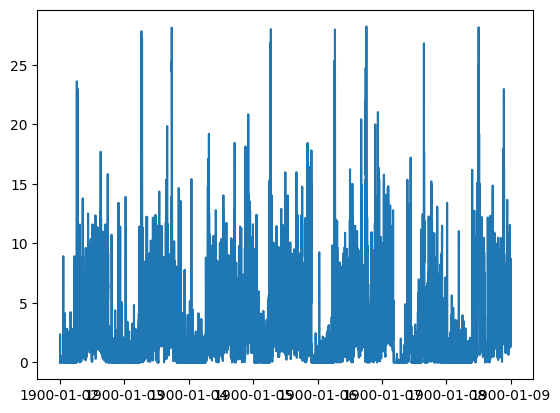

In [20]:
import matplotlib.pyplot as plt
plt.plot(data['x'])
plt.show()

In [ ]:
loader = DataLoader(datasource='nhanes', input_path='../data', person_id=62164)
loader.load_data()
loader.get_enmo_data().head()